In [1]:
# Computations
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import statsmodels.formula.api as smf

# Progressbar
import progressbar

# sklearn data
import sklearn
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, r2_score

# Train and Test sets splitting
from sklearn.model_selection import train_test_split

# Regressors
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

# plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#### Table of Contents

* [Dataset](#Dataset)
* [Data Exploration](#Data-Exploration)
* [Generalized Linear Models](#Generalized-Linear-Models)
    * [Ordinary Least Squares](#Ordinary-Least-Squares)
    * [Ridge](#Ridge)
    * [Lasso](#Lasso)
    * [Elastic-Net](#Elastic-Net)
    * [Least Angle Regressions (LARS)](#Least-Angle-Regressions-(LARS))
    * [LARS Lasso](#LARS-Lasso)
    * [Orthogonal Matching Pursuit](#Orthogonal-Matching-Pursuit)
    * [Bayesian Regression](#Bayesian-Regression)
    * [Huber Regressor](#Huber-Regressor)
    * [Random Sample Consensus (RANSAC)](#Random-Sample-Consensus-(RANSAC))
* [Other Models](#Other-Models)
    * [Kernel Ridge Regression](#Kernel-Ridge-Regression)
    * [Neural Network Regression Model (Supervised)](#Neural-Network-Regression-Model-(Supervised))
    * [Decision Tree Regression](#Decision-Tree-Regression)
    * [Gradient Boosted Tree](#Gradient-Boosted-Tree)
* [Conclusion](#Conclusion)

# Dataset

Attribute Information (in order):

| Attribute | Attribute Information |
|-----------|-----------------------------------------------------------------------|
| CRIM | per capita crime rate by town |
| ZN | proportion of residential land zoned for lots over 25,000 sq.ft. |
| INDUS | proportion of non-retail business acres per town |
| CHAS | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| NOX | nitric oxides concentration (parts per 10 million) |
| RM | average number of rooms per dwelling |
| AGE | proportion of owner-occupied units built prior to 1940 |
| DIS | weighted distances to five Boston employment centres |
| RAD | index of accessibility to radial highways |
| TAX | full-value property-tax rate per $\$10,000$ |
| PTRATIO | pupil-teacher ratio by town |
| B | $1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town |
| LSTAT | $\%$ lower status of the population |
| MEDV | Median value of owner-occupied homes in $\$1000$â€™s |

Source:
- [https://scikit-learn.org/stable/datasets/index.html](https://scikit-learn.org/stable/datasets/index.html)
- [https://archive.ics.uci.edu/ml/machine-learning-databases/housing/](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/)

In [2]:
# Loading the dataset from sklearn datasets
Temp = load_boston()
Data = pd.DataFrame(Temp.data)
Data.columns = Temp.feature_names
del Temp
# Adding MEDV column from the original source
Temp = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                   delimiter= '\s+', index_col=False, header=None)
Data['MEDV'] = Temp.iloc[:,-1]
del Temp
# Saving as a CSV file
Data.to_csv('Data/Housing_Data.csv',index=False)
# The Dataset
Data.head().style.hide_index()

In [3]:
Data.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT        MEDV  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

# Data Exploration

First, let's define some functions.

In [4]:
def High_Correlated_Attributes(Df, threshold = 0.5):
    Correlation_Matrix = Df.corr()
    Temp = Correlation_Matrix[Correlation_Matrix>= threshold]
    Temp1 = Temp.notnull().sum()
    Temp1 = Temp1[Temp1 == Temp1.max()].index.tolist()[0]
    Temp = Temp[Temp1].dropna()
    mylist = Temp.index.tolist()
    return mylist

In [5]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr()
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("RdYlGn", n_colors=10), linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .5})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

In [6]:
# Highly correlated attributes:
Temp = Data[High_Correlated_Attributes(Data)]

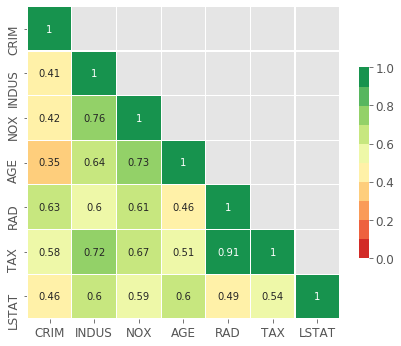

In [7]:
Correlation_Plot (Temp,len(High_Correlated_Attributes(Data)))

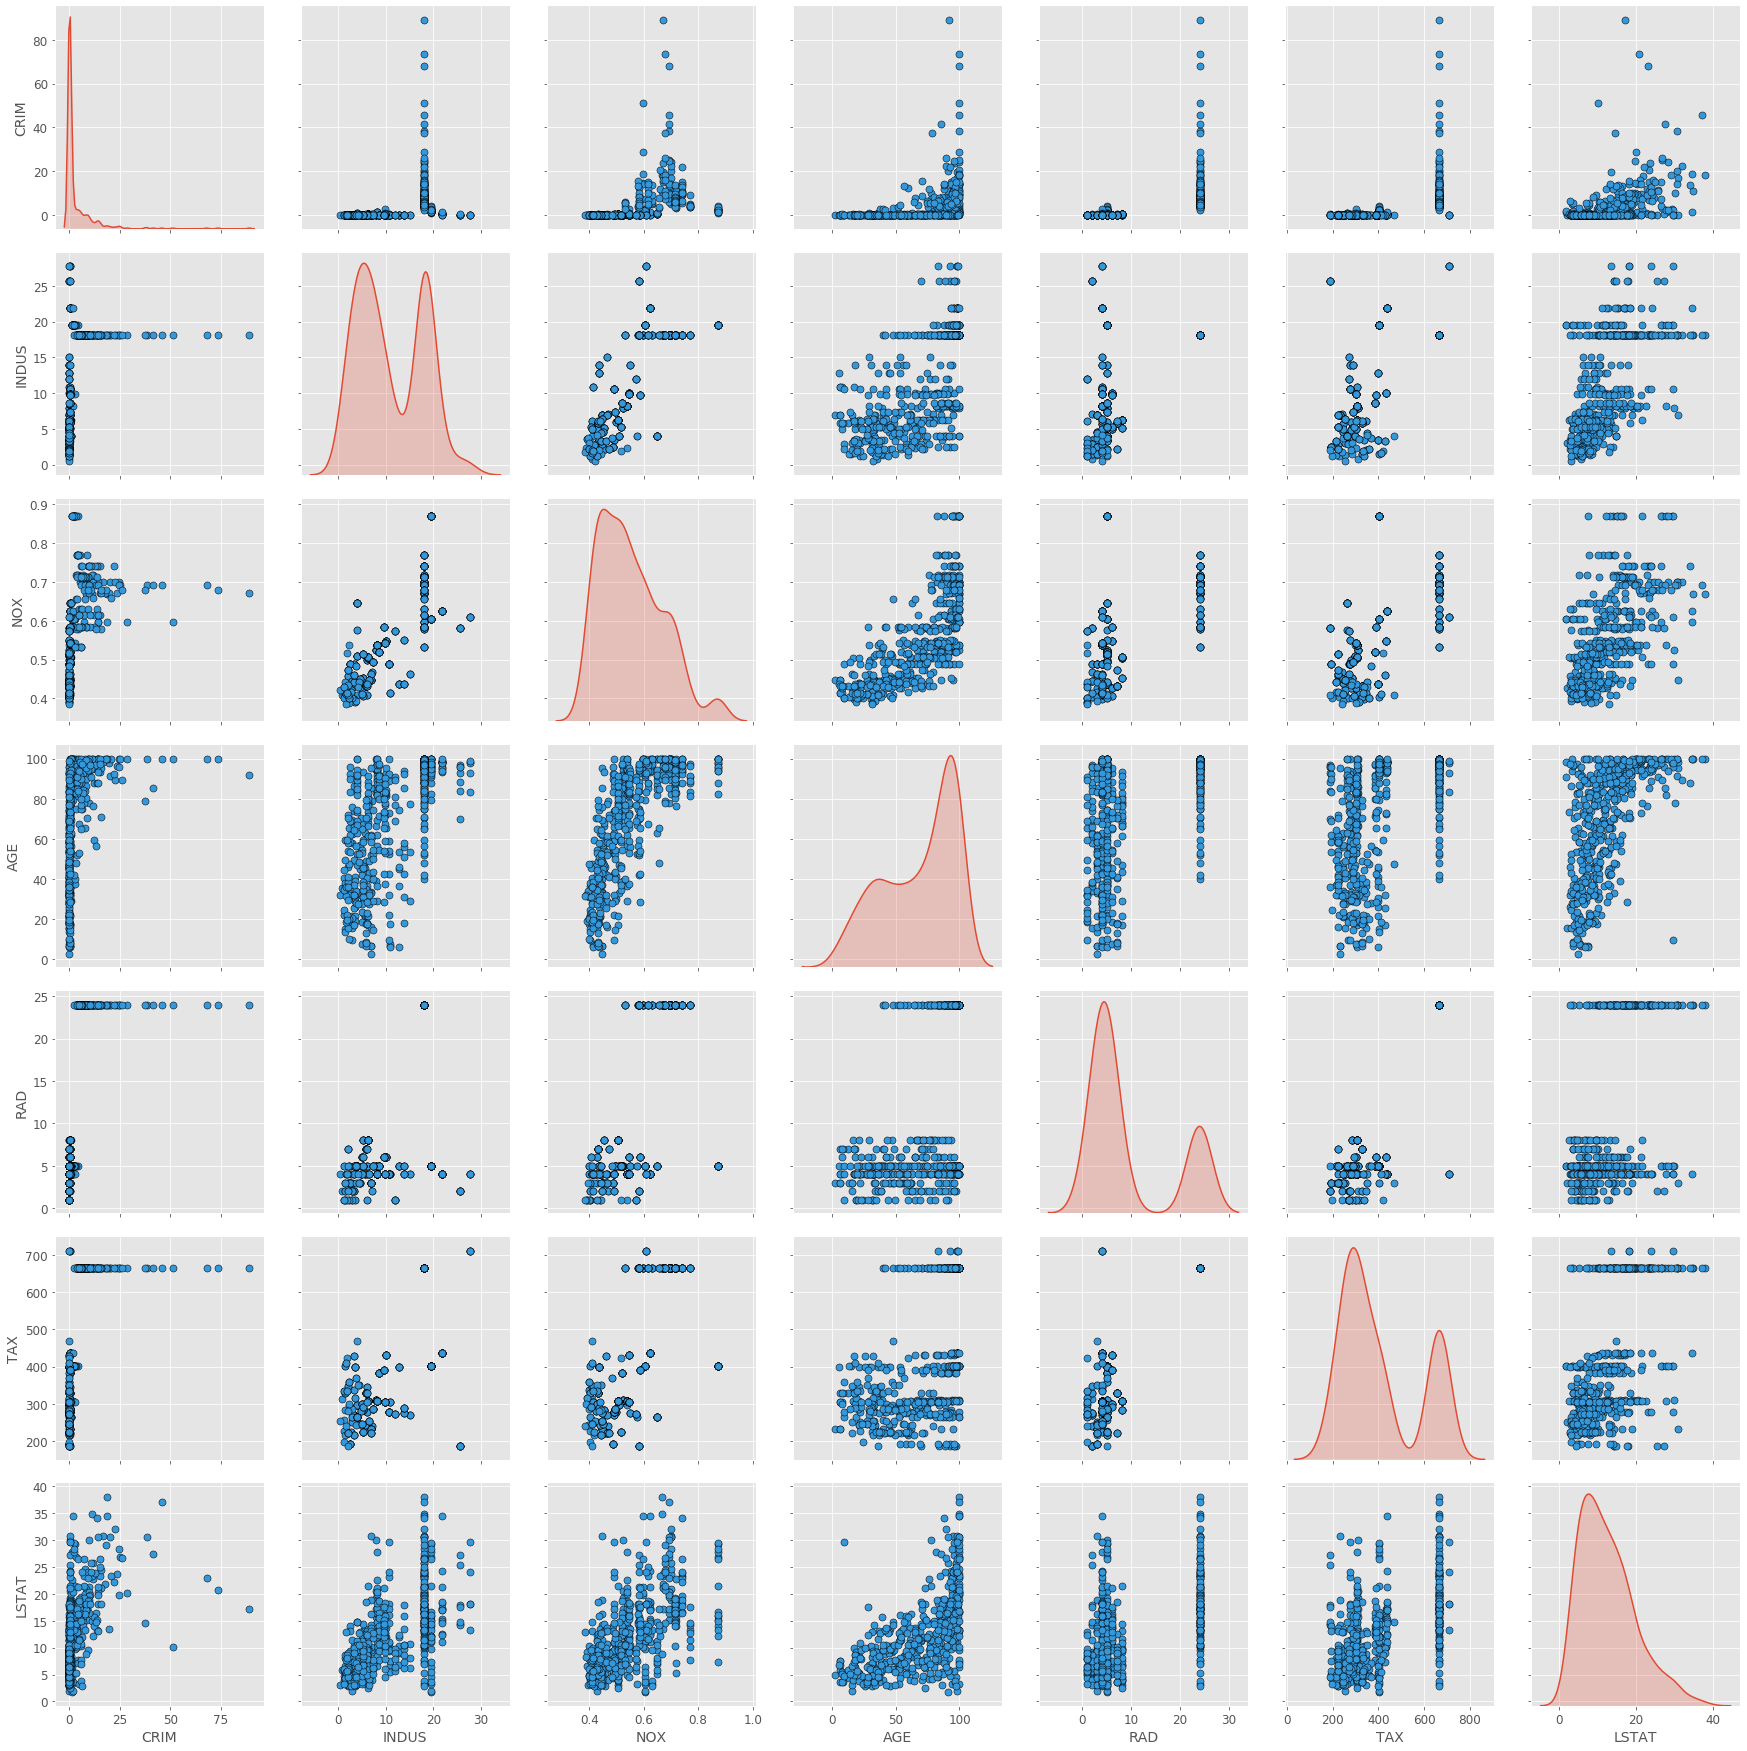

In [8]:
_ = sns.pairplot(Temp, height=3.5,diag_kind="kde",
                 plot_kws=dict(s=50, color="#3498db", edgecolor="k", linewidth=0.5),diag_kws=dict(shade=True))

A univariate distribution of observations:

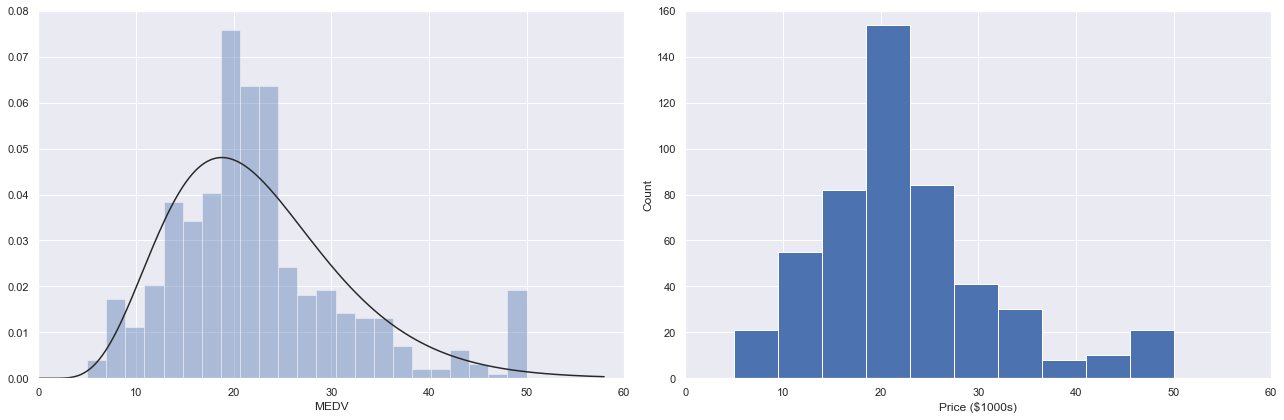

In [9]:
sns.set(color_codes=True)

fig, ax = plt.subplots(1,2, figsize=(18,6))
_ = sns.distplot(Data.MEDV, kde=False, fit=stats.gamma, ax=ax[0])
_ = ax[0].set_xlim([0, 60])
_ = ax[0].set_ylim([0, 0.08])

_ = ax[1].hist(Data.MEDV)
_ = ax[1].set_xlabel('Price ($1000s)')
_ = ax[1].set_ylabel('Count')
_ = ax[1].set_xlim([0, 60])
_ = ax[1].set_ylim([0, 160])

plt.tight_layout()

# Train and Test Sets

In [10]:
X = Data.drop(columns='MEDV')
y = Data.MEDV
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
             'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).style.hide_index()

In the next section, we use the following function for plotting.

In [12]:
sns.set(color_codes=True)

def Plot_Reg_Results(Expected, Predicted, Reg):
    fig, ax = plt.subplots(figsize=(10,5))
    _ = ax.scatter(Expected, Predicted)
    N = int(np.max(np.ceil([np.max(Expected), np.max(Predicted)])))+10
    _ = ax.plot([0, N], [0, N], '--k')
    _ = ax.set_xlabel('True price ($1000s)', fontsize=14)
    _ = ax.set_ylabel('Predicted price ($1000s)', fontsize=14)
    _ = ax.set_xlim([0, N])
    _ = ax.set_ylim([0, N])

    plt.tight_layout()

Moreover, we can create a table for later comparisons.

In [13]:
Results = pd.DataFrame(data={'Regression': ['Ordinary Least Squares'],'Score':'', 'MSE':'', 'Variance score':''})
Results = Results.set_index('Regression')
Results

Score MSE Variance score
Regression                                     
Ordinary Least Squares

Next, we compare several regression models in terms of score, MSE, and Variance score.

# Generalized Linear Models

## Ordinary Least Squares

Score     MSE Variance score
Regression                                             
Ordinary Least Squares  0.733884  36.045       0.616015

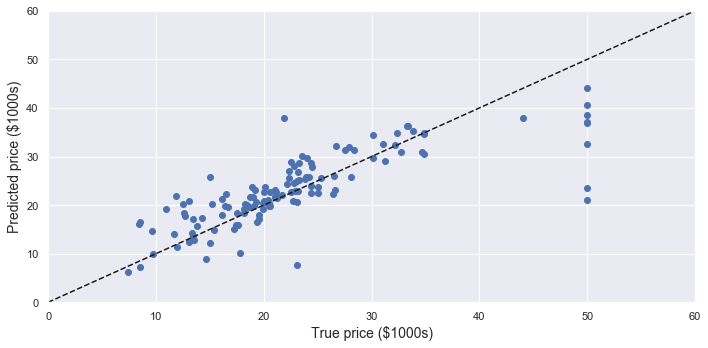

In [14]:
Reg = 'Ordinary Least Squares'
clf = linear_model.LinearRegression()

# the model
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Ridge

In [15]:
clf = linear_model.RidgeCV(alphas=np.logspace(-3, 3, 200))
clf.fit(X_train, y_train)

clf.alpha_

0.0644236350872137

Score      MSE Variance score
Regression                                              
Ordinary Least Squares  0.733884   36.045       0.616015
Ridge                   0.733709  36.0975       0.615456

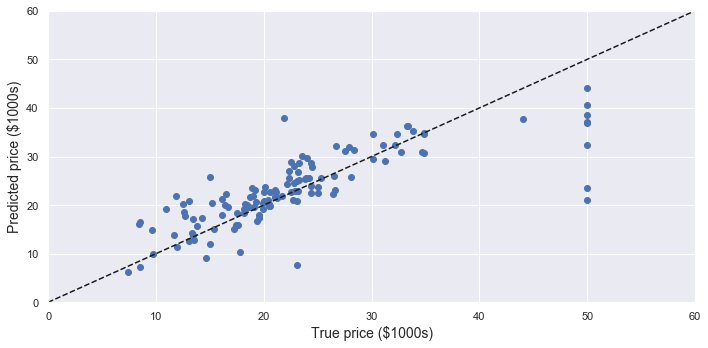

In [16]:
Reg = 'Ridge'

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Lasso

In [17]:
clf = linear_model.LassoCV(alphas=np.logspace(-3, 3, 200))
clf.fit(X_train, y_train)

clf.alpha_

0.0012315506032928262

Score      MSE Variance score
Regression                                              
Ordinary Least Squares  0.733884   36.045       0.616015
Ridge                   0.733709  36.0975       0.615456
Lasso                   0.733778   36.079       0.615653

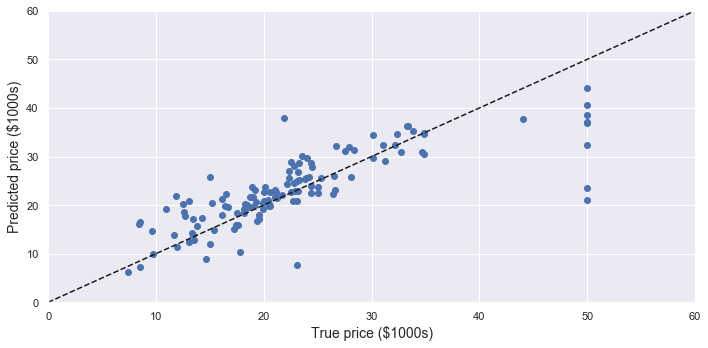

In [18]:
Reg = 'Lasso'

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Elastic-Net

Score      MSE Variance score
Regression                                              
Ordinary Least Squares  0.733884   36.045       0.616015
Ridge                   0.733709  36.0975       0.615456
Lasso                   0.733778   36.079       0.615653
Elastic-Net             0.687382  36.9221       0.606672

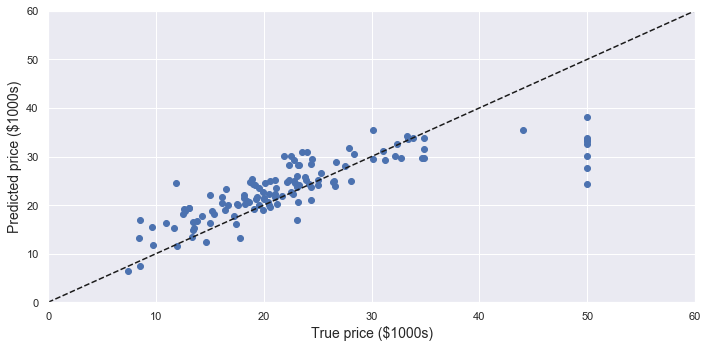

In [19]:
Reg = 'Elastic-Net'

clf = linear_model.ElasticNet(random_state=0)
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Least Angle Regressions (LARS)

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664

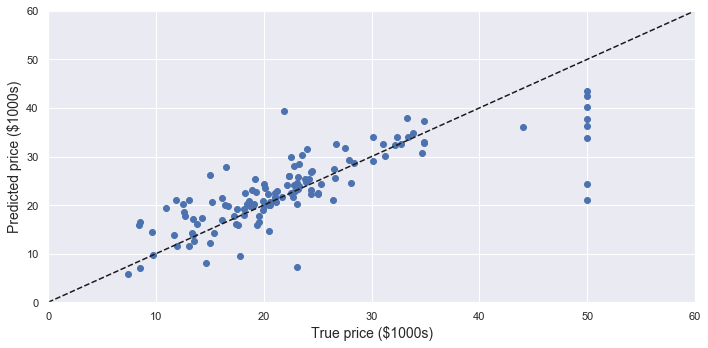

In [20]:
Reg = 'Least Angle Regressions (LARS)'

clf = linear_model.Lars(n_nonzero_coefs = len(X_train.columns))
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## LARS Lasso

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664
LARS Lasso                      0.733637  36.0765        0.61568

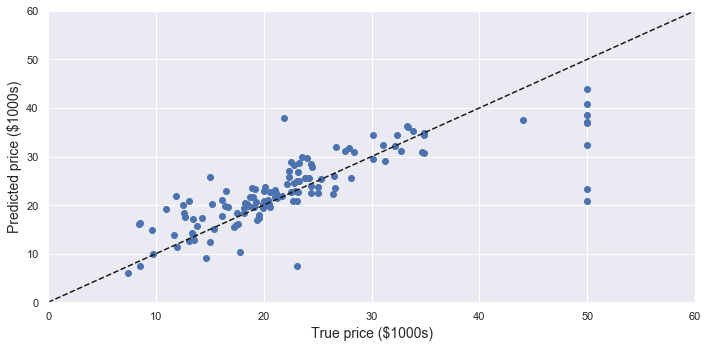

In [21]:
Reg = 'LARS Lasso'

clf = linear_model.LassoLars(alpha=.001)
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Orthogonal Matching Pursuit

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664
LARS Lasso                      0.733637  36.0765        0.61568
Orthogonal Matching Pursuit     0.733884   36.045       0.616015

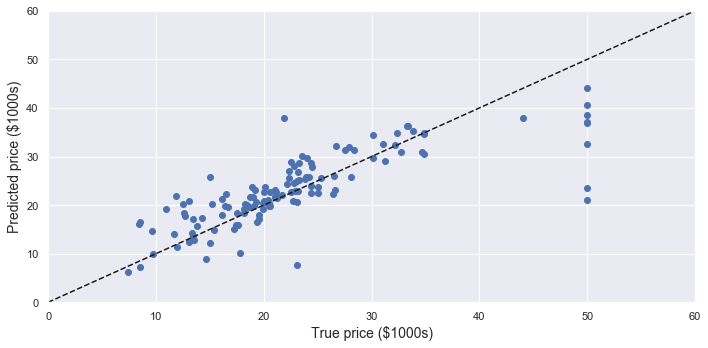

In [22]:
Reg = 'Orthogonal Matching Pursuit'

clf = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs= len(X_train.columns))
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Bayesian Regression

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664
LARS Lasso                      0.733637  36.0765        0.61568
Orthogonal Matching Pursuit     0.733884   36.045       0.616015
Bayesian Regression             0.725487  37.1362       0.604391

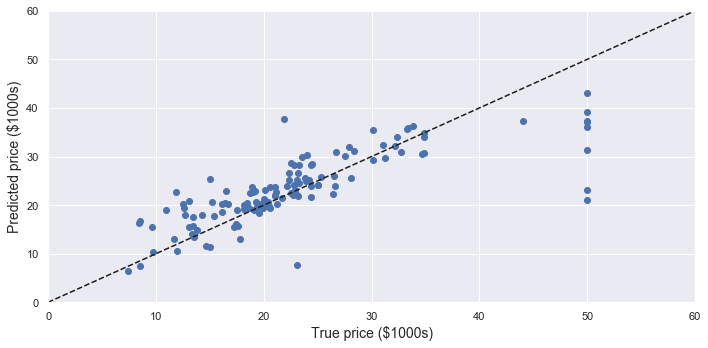

In [23]:
Reg = 'Bayesian Regression'

clf = linear_model.BayesianRidge()
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Huber Regressor

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664
LARS Lasso                      0.733637  36.0765        0.61568
Orthogonal Matching Pursuit     0.733884   36.045       0.616015
Bayesian Regression             0.725487  37.1362       0.604391
Huber Regressor                 0.694662  41.8761       0.553897

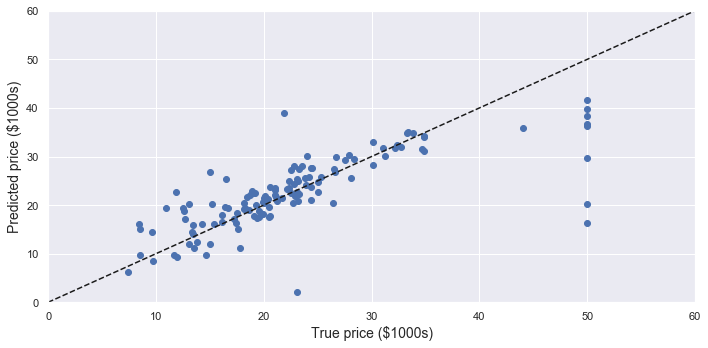

In [24]:
Reg = 'Huber Regressor'

clf = linear_model.HuberRegressor()
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Random Sample Consensus (RANSAC)

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664
LARS Lasso                      0.733637  36.0765        0.61568
Orthogonal Matching Pursuit     0.733884   36.045       0.616015
Bayesian Regression             0.725487  37.1362       0.604391
Huber Regressor                 0.694662  41.8761       0.553897
RANSAC                           0.51944  50.7298       0.459579

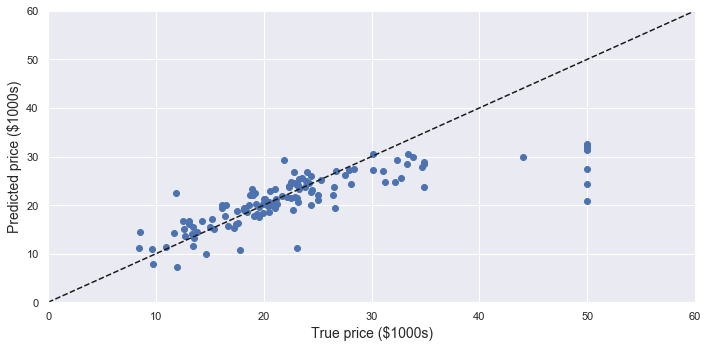

In [25]:
Reg = 'RANSAC'

clf = linear_model.RANSACRegressor()
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

# Other Models

## Kernel Ridge Regression

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664
LARS Lasso                      0.733637  36.0765        0.61568
Orthogonal Matching Pursuit     0.733884   36.045       0.616015
Bayesian Regression             0.725487  37.1362       0.604391
Huber Regressor                 0.694662  41.8761       0.553897
RANSAC                           0.51944  50.7298       0.459579
Kernel Ridge Regression         0.708636  41.0493       0.562705

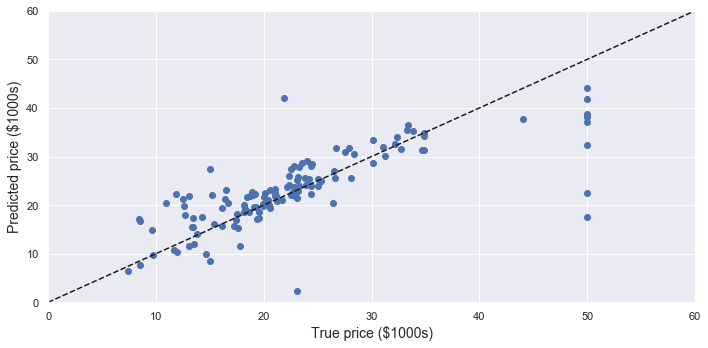

In [26]:
Reg = 'Kernel Ridge Regression'

clf = KernelRidge(alpha=1.0)
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Neural Network Regression Model (Supervised)

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664
LARS Lasso                      0.733637  36.0765        0.61568
Orthogonal Matching Pursuit     0.733884   36.045       0.616015
Bayesian Regression             0.725487  37.1362       0.604391
Huber Regressor                 0.694662  41.8761       0.553897
RANSAC                           0.51944  50.7298       0.459579
Kernel Ridge Regression         0.708636  41.0493       0.562705
MLP Regressor                   0.654251  37.0856       0.604929

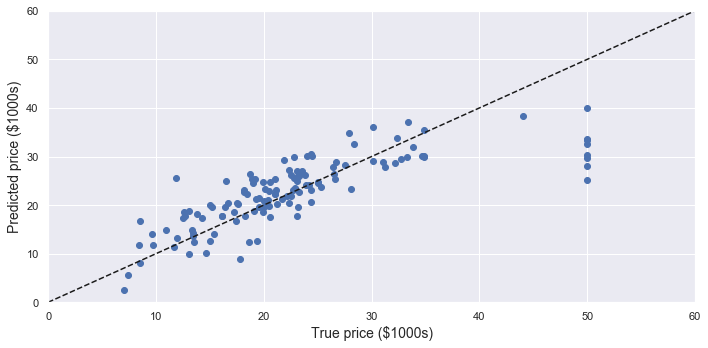

In [27]:
Reg = 'MLP Regressor'

clf = MLPRegressor()
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

 ## Decision Tree Regression

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664
LARS Lasso                      0.733637  36.0765        0.61568
Orthogonal Matching Pursuit     0.733884   36.045       0.616015
Bayesian Regression             0.725487  37.1362       0.604391
Huber Regressor                 0.694662  41.8761       0.553897
RANSAC                           0.51944  50.7298       0.459579
Kernel Ridge Regression         0.708636  41.0493       0.562705
MLP Regressor                   0.654251  37.0856       0.604929
Decision Tree Regression        0.901786  33.0341        0.64809

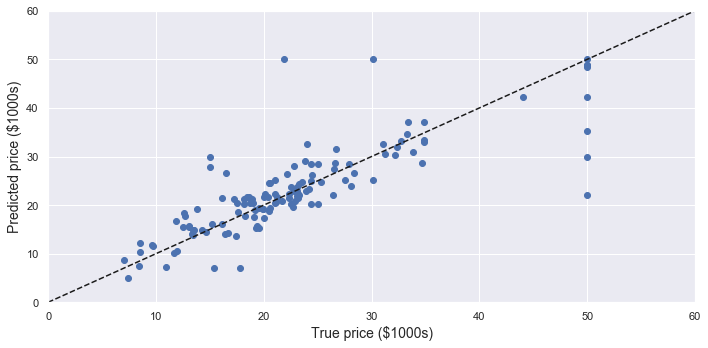

In [28]:
Reg = 'Decision Tree Regression'

clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

## Gradient Boosted Tree

We also can use the Gradient Boosting Regressor.

Score      MSE Variance score
Regression                                                      
Ordinary Least Squares          0.733884   36.045       0.616015
Ridge                           0.733709  36.0975       0.615456
Lasso                           0.733778   36.079       0.615653
Elastic-Net                     0.687382  36.9221       0.606672
Least Angle Regressions (LARS)  0.712203  37.2045       0.603664
LARS Lasso                      0.733637  36.0765        0.61568
Orthogonal Matching Pursuit     0.733884   36.045       0.616015
Bayesian Regression             0.725487  37.1362       0.604391
Huber Regressor                 0.694662  41.8761       0.553897
RANSAC                           0.51944  50.7298       0.459579
Kernel Ridge Regression         0.708636  41.0493       0.562705
MLP Regressor                   0.654251  37.0856       0.604929
Decision Tree Regression        0.901786  33.0341        0.64809
Gradient Boosted Tree           0.946735  12.3892       0.868019

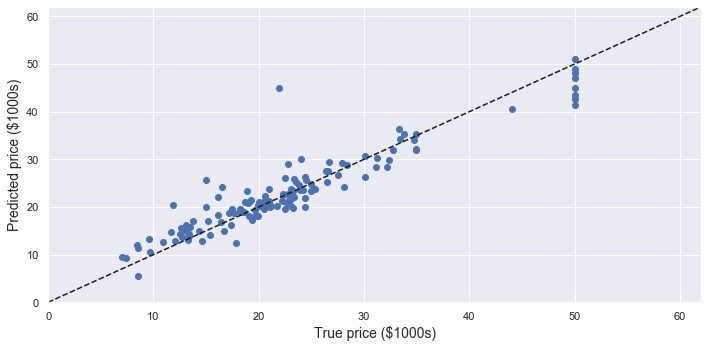

In [29]:
Reg = 'Gradient Boosted Tree'

clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)

# Predicted Values
Predicted = clf.predict(X_test)
# Expected Values
Expected = y_test

# the plot
Plot_Reg_Results(Expected, Predicted, Reg)

# the table
Results.loc[Reg,:] = [clf.score(X, y), mean_squared_error(Expected, Predicted),
                                      r2_score(Expected, Predicted)]
Results

# Conclusion

The best results in the example are coming from:

In [30]:
Results.Score[Results.Score == Results.Score.max()].index[0]

'Gradient Boosted Tree'

The accuracy of predictions can vary depending on the setting that we implement in each regression.

***